This is the second in a series of posts in which I explore concepts in Andrew Ng's [Introduction to Machine Learning](https://www.coursera.org/learn/machine-learning) course on Coursera.  In each, I'm implementing in Python an algorithm taught in the class:  first using standard Python data science and numerical tools, and then in [Tensorflow](https://www.tensorflow.org/).

The second algorithm is is [logistic regression](link).  Logistic regression is recognizably similar to [linear regression](link self), but instead of predicting a continuous output, classifies training examples by a set of categories or labels.  For example, linear regression on a set of social and economic data might be used to predict a person's income, but logistic regression could be used to predict whether that person was married, had children, or had ever been arrested.  In a basic sense, logistic regression only answers questions that have yes / no answers, or questions that can be answered with one or zero.  However, it can easily be [extended](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to problems where there are a larger set of categories.

For this algorithm, I'm using the [Wine](https://archive.ics.uci.edu/ml/datasets/Wine) dataset from UCI. It maps thirteen continuous variables representing chemical contents of a wine to three labels, each a different winery in Italy.

# Loading and Plotting Data
 
The first step is to load the data.  Initially, I'm only using two features from the data set: alcohol and ash.  The labels are supplied as an array of data with values from one to three, but to start with, I only want a simple regression problem with a yes or no answer.  

To do this, I first get a reduced data set, filtered so that it only includes wines with labels `1` or `2`, and then I use the scikit-learn `label_binarize` function.  `label_binarize`  takes an $m$-length list with $n$ possible values (two, in this case), and converts it to an $m \times n$ matrix, where each column represents one label with a value of `1`, and all others with a value of `0`.  Then, I choose the first column.

I've provided a small example below with 10 elements taken from a shuffled list of labels (the data set is ordered by winery, so the first ten of the unsorted array would all be `1`).

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

data = pd.read_csv('data.txt')

reduced = data[data['class'] <= 2]
X = reduced.as_matrix(columns=['alcohol', 'ash'])
y = label_binarize(reduced['class'].values, [1, 2])[:,0]

example = np.copy(data['class'].values)
np.random.shuffle(example)
example = example[0:10]
print('original:', example)
example = label_binarize(example, list(set(example)))
print('binarized:', example)
print('1s vs all:', example[:,0])

original: [2 3 2 1 3 2 3 2 3 2]
binarized: [[0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]]
1s vs all: [0 0 0 1 0 0 0 0 0 0]


I also split the data into training and testing sets before going further.  A simple way to do this is with the `train_test_split` function from scikit-learn, which allows me to specify a percentage (here 20%) to sample randomly from the data set and partition away for testing.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('train:', len(X_train), 'test:', len(X_test))

train: 104 test: 26


Because I'm going to be drawing a lot of data plots, I define a function that takes an $n \times 2$ array of data points `xy`, and an $n \times 1$ array `labels` to vary the symbol and color for each point.  This function supports three distinct labels, sufficient for this data set.

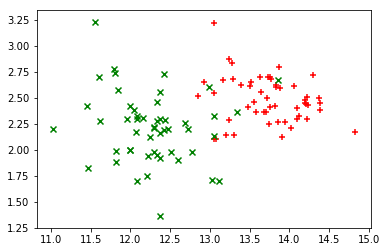

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train)

There's a fairly obvious area near the center of the plot where a vertical line could divide the two colors of points with a small amount of error.

# Simple Logistic Regression

To implement logistic regression, I need a hypothesis function $h_\theta(x)$, a cost function $J(\theta)$, and a gradient function that computes the partial derivatives of $J(\theta)$.

In logistic regression, $h_\theta$ is the [sigmoid](https://www.quora.com/Logistic-Regression-Why-sigmoid-function) function.  The sigmoid function is bounded between zero and one, and produces a value that can be interpreted as a probability, as well as a yes or no answer with a cross-over, or decision boundary at 0.5:

$$
h_\theta(x) = \frac{1}{1 + e^{ \theta^Tx}}
$$

Using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) from linear regression isn't a good idea here, as the resulting cost function [isn't convex](http://mathworld.wolfram.com/SigmoidFunction.html) and so is not well-suited for gradient descent.  Instead, the difference of $h_\theta(x^i) - y^i$ is calculated differently for $y=0$ and $y=1$, and the result is [transformed](https://stackoverflow.com/questions/32986123/why-the-cost-function-of-logistic-regression-has-a-logarithmic-expression) [logarithmically](https://math.stackexchange.com/questions/886555/deriving-cost-function-using-mle-why-use-log-function) into a convex function: 

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))
$$

Fortunately, the [derivative](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression) of this function is exactly the same as that of linear regression, just with a different $h_\theta(x)$:

$$
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i
$$

In [4]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))
    
    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]
    
    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

It's worth noting the treatment of `y` and `theta` above.  In each function, I explicitly convert each to an $n$ or $m \times 1$ `ndarray`, so the linear algebra works correctly.  An alternative is to use a numpy `matrix`, which has stricter linear algebra semantics and treats 1-dimensional matrices more like column vectors.  However, I found that it was awkward to get the matrix interface to work correctly with both the optimization function used below and Tensorflow.  The syntax `theta = theta[:,None]` can be thought of as explicitly columnizing the array of parameters or labels.

Instead of manually writing the gradient descent algorithm, I use an optimization algorithm from Scipy called [`fmin_tnc`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) to perform it.  This function takes as parameters the cost function, an initial set of parameters for $\theta$, the gradient function, and a tuple of args to pass to each.  I define a `train` function that prepends a columns of ones to the training data (allowing for a bias parameter $\theta_0$), run call the minimization function and returning the first of its return values, final parameters for $\theta$.

In [5]:
from scipy.optimize import fmin_tnc  

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
    
    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

theta:  [ 85.36930697  -5.94038827  -3.38665516]


# Decision Boundaries and Evaluation


I can evaluate the results of the optimization visually and statistically, but I also need one more function: `predict`, which takes an array of examples `X` and learned parameter values `theta` as inputs and returns the predicted label for each.  Here too, ones must be prepended to the inputs, and I return an integer value representing whether the result of the `sigmoid` hypothesis function is equal to or greater than 0.5.

To test the results of those predictions, Scikit-learn provides three functions to calculate accuracy, [precision](https://en.wikipedia.org/wiki/Precision_and_recall), and [recall](https://en.wikipedia.org/wiki/Precision_and_recall).  The test data from earlier is used here, so the results represent the performance of the classifier on unseen data.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict(X, theta):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    return (sigmoid(X * np.matrix(theta).T) >= 0.5).astype(int)

predictions = predict(X_test, theta)

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.884615384615
precision: 0.830827067669
recall: 0.866666666667


Not bad for a first attempt, but could certainly be improved.

It's much more interesting to review the results visually, at least while the number of features is limited to two.  To do this, I need to plot the input points again, then overlay the decision boundary on top.  I tried a few methods of representing this in Matplotlib, and found that an (unfilled) countour plot was the best approach.  It's possible to do this also by manually calculating the function to plot, or to produce a filled contour plot that shades the background, but doing the math by hand is tedious and won't scale, and the colormaps for filled contour plots leave a lot to be desired visually.

Below, I define a function `plot_boundary` that takes $n$ by 2 matrix of feature values $(x_0, x_1)$ and a prediction function, then builds a mesh grid of $(x, y)$ points corresponding to possible $(x_0, x_1)$ values within the input range.  After running the prediction function on all of them, the result is an $(x, y, z)$ point in space.  Because the result isn't continuous and flips directly from zero to one, there's only one contour that can be drawn on the plot, representing the decision boundary.

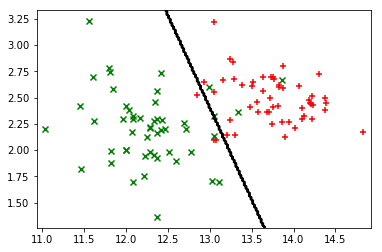

In [7]:
from matplotlib import cm

def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)

    plt.contour(xs, ys, zs, colors='black')
        
plot_points(X_train, y_train)
plot_boundary(X_train, lambda x: predict(x, theta))

That seems like an entirely reasonable place to make a decision between the two kind of points.  Below is the same decision boundary on the test data.

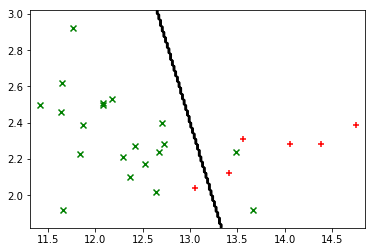

In [8]:
plot_boundary(X_test, lambda x: predict(x, theta))
plot_points(X_test, y_test)

### Multinomial Logistic Regression

The next step is something more interesting: a similar set of two features from the data set (this time alcohol and flavanoids), but with all three labels instead of the first one vs the other two.  The only differences below in loading the data are that I no longer filter out rows with the third label, that I use the full output from `label_binarize`, resulting in an $m \times 3$ array for `y`.

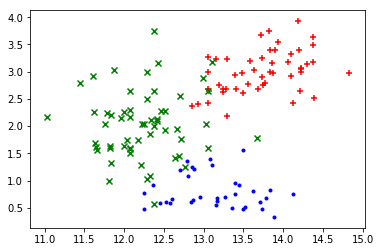

In [9]:
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = label_binarize(y_train, [1, 2, 3])

plot_points(X_train, y_train.argmax(axis=1))

The plotted data points again suggest some obvious linear boundaries between the wines.

It turns out that solving this as three one-vs-all problems is trivial.  Instead of one array of `theta` values I train three, one per problem, and then define a new `predict_multi` function that computes the sigmoid for each set of `theta` parameters.  This time, rather than return `1` or `0` based on whether the value is above or below 0.5, I return the `argmax` of each row, or the index of the largest value.

accuracy: 0.916666666667
precision: 0.915584415584
recall: 0.928571428571


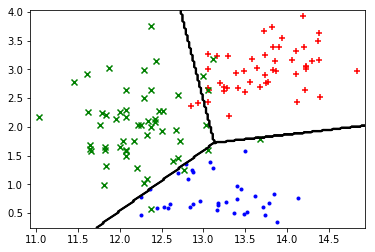

In [10]:
def predict_multi(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(x, thetas))

That's pretty good.  But there's still room for improvement, even while only using two features from the data set.  Looking at the plot above, it seems like the boundaries could be much more accurate if they didn't have to be straight lines.

To allow for this, I define a function `transform` to add some polynomial features, converting each input example of $(x_0, x_1)$ to $(x_0, x_1, x_2, x_3, x_4)$, where $x_2 = x_0^2$, where $x_3 = x_1^2$ and $x_4 = x_0 x_1$.

accuracy: 0.916666666667
precision: 0.915584415584
recall: 0.928571428571


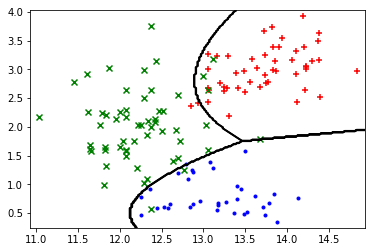

In [11]:
def transform_x(x):
    return [x[0], x[1], x[0] ** 2, x[1] ** 2, x[0] * x[1]]

def transform(X):
    return np.apply_along_axis(transform_x, 1, X)

X_train = transform(X_train)
X_test = transform(X_test)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(transform(x), thetas))

# Regularization

Next, I want to include all the features from the data set.  To do this, instead of specifying what columns I want to include, I use `drop` to include everything except the `class`.

Because I'm now significantly increasing the number of features, I apply [regularization](https://www.quora.com/What-is-regularization-in-machine-learning) as part of new cost and gradient functions.  Regularization prevents overfitting, a situation where a large number of features allows the classifier to fit the training set *too* exactly, meaning that it fails to generalize well and perform accurately on data it hasn't seen yet.

To avoid this problem, I add an additional term to the cost function and its gradient, representing the aggregated weights of each $\theta$ parameter.  Adding this term effectively increases the cost, meaning that one parameter is significantly less likely to over-influence the classifier overall, and the fit to the training set is softened.  That parameter looks different for the cost function and its gradient.  Note that for each, the summation for regularization starts at $j = 1$, since the constant bia parameter $\theta_0$ is typically not regularized:

$$
J(\theta) =-\frac{1}{m}\sum_{i=1}^{m}[y^{i}\log(h_\theta(x^{i}))+(1-y^{i})\log(1-h_\theta(x^{i}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2 \\
\frac{\partial}{\partial\theta_{j}}J(\theta) =\sum_{i=1}^{m}(h_\theta(x^{i})-y^i)x_j^i + \frac{\lambda}{m}\theta_j
$$

Below, I define new cost and gradient functions, and then a new function to train the classifier, given the addition of a new parameter `l`, for $\lambda$.  This parameter can be adjusted to change the effect of regularization; here I'm simply using `1.0` for its value.  In each case, I ensure that $\theta_0$ isn't regularized by creating a temporary `theta_reg`, starting with a zero followed by elements one and onward from `theta`.

In [12]:
X = data.drop('class', 1).as_matrix()
y = data.as_matrix(columns=['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = label_binarize(y_train, [1, 2, 3])

def cost_reg(theta, X, y, l):
    theta_reg = np.array((0, *theta[1:]))
    return cost(theta, X, y) + l * np.square(theta_reg).sum() / (2 * len(X))

def gradient_reg(theta, X, y, l):
    theta_reg = np.array((0, *theta[1:]))[:,None]
    return gradient(theta, X, y) + l * theta_reg / len(X)

def train_reg(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost_reg, x0=theta, fprime=gradient_reg, args=(X, y, 1.0))
    
    return result[0]

thetas = [train_reg(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

accuracy: 0.972222222222
precision: 0.966666666667
recall: 0.982456140351


With all features now in use, the accuracy is quite good.

# Logistic Regression in Tensorflow

In [13]:
data = pd.read_csv('data.txt')

#def transform_data(x):

X = data.as_matrix(columns=['alcohol', 'flavanoids'])
#XX = data.drop('class', 1).as_matrix()
y = label_binarize(data['class'], [1, 2, 3])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('train:', len(X_train), 'test:', len(X_test))

train: 142 test: 36


weights: [[ 16.20529938 -25.64712524   9.44766712]
 [ 25.65550232   7.0128417  -32.6669693 ]]
bias: [-258.31646729  322.18566895  -63.87068176]
accuracy: 0.944444444444
precision: 0.947058823529
recall: 0.939393939394


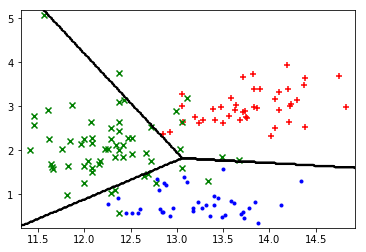

In [17]:
import tensorflow as tf

def tf_generate(n_features, n_labels):

    examples = tf.placeholder(tf.float32, [None, n_features], name='examples')
    labels = tf.placeholder(tf.int32, [None, n_labels], name='y')

    weights = tf.Variable(tf.zeros([n_features, n_labels]), name='weights')
    bias = tf.Variable(tf.zeros([n_labels]), name='bias')

    logits = tf.matmul(examples, weights) + bias
    predict = tf.nn.softmax(logits)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    opti = tf.train.GradientDescentOptimizer(1).minimize(cost)
    
    return opti, predict

def tf_run(X_train, X_test, y_train, y_test):
    pass

n_features = X_train.shape[1]
n_labels = y_train.shape[1]

examples = tf.placeholder(tf.float32, [None, n_features], name='examples')
labels = tf.placeholder(tf.int32, [None, n_labels], name='y')

weights = tf.Variable(tf.zeros([n_features, n_labels]), name='weights')
bias = tf.Variable(tf.zeros([n_labels]), name='bias')

logits = tf.matmul(examples, weights) + bias
predict = tf.nn.softmax(logits)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
opti = tf.train.GradientDescentOptimizer(1).minimize(cost)

init = tf.global_variables_initializer()

def predict_tf(session, inputs):
    return session.run(predict, feed_dict={examples: inputs}).argmax(axis=1)
    
with tf.Session() as sess:
    sess.run(init)

    for i in range(120000):
        sess.run(opti, feed_dict={
            examples: X_train,
            labels: y_train
        })

    pred = predict_tf(sess, X_test)

    print('weights:', sess.run(weights))
    print('bias:', sess.run(bias))
    print('accuracy:', accuracy_score(y_test.argmax(axis=1), pred))
    print('precision:', precision_score(y_test.argmax(axis=1), pred, average='macro'))
    print('recall:', recall_score(y_test.argmax(axis=1), pred, average='macro'))

    plot_boundary(X_train, lambda i: predict_tf(sess, i))
    plot_points(X_train, y_train.argmax(axis=1))

In [15]:
def transform_data(x):
#    return x
    #return [x[0], x[1], x[0] ** 2, x[1] ** 2]

data = pd.read_csv('data.txt')
X = data.as_matrix(columns=['alcohol', 'flavanoids'])
#XX = data.drop('class', 1).as_matrix()
#y = np.array([i - 1 for i in data['class']])


#X = np.apply_along_axis(transform_data, 1, X)
y = label_binarize(data['class'], [1, 2, 3])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('train:', len(X_train), 'test:', len(X_test))

IndentationError: expected an indented block (<ipython-input-15-7cca0ca93ab1>, line 5)